In [5]:
import pandas as pd
import numpy as np
import wrds
from matplotlib import pyplot as plt

In [6]:
from sqlalchemy import text

In [7]:
db = wrds.Connection(wrds_username='user2294')
#kCBF.zEqH5*,6:c

Loading library list...
Done


In [8]:
###################
# Compustat Block Accounting #
###################
comp = db.raw_sql(text("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk, fic, csho, prcc_c
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1926'
                    and (fic = 'JPN' or fic = 'USA' or fic = 'DNK')
                    """), date_cols=['datadate'])


In [9]:
comp['year']=comp['datadate'].dt.year

# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0)

# create book equity add deferred tax and subtract preferred shares
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count', 'fic','csho', 'prcc_c' ]]

In [12]:
jpn_be = comp[comp['fic'] == 'JPN'].copy()
usa_be = comp[comp['fic'] == 'USA'].copy()
dnk_be = comp[comp['fic'] == 'DNK'].copy()
jpn_be['beme'] = jpn_be['be'] / (jpn_be['csho'] * jpn_be['prcc_c'])
usa_be['beme'] = usa_be['be'] /  (usa_be['csho'] * usa_be['prcc_c'])
dnk_be['beme'] = dnk_be['be'] / (dnk_be['csho'] * dnk_be['prcc_c'])

jpn_be.dropna(subset=['beme'], inplace=True)
usa_be.dropna(subset=['beme'], inplace=True)
dnk_be.dropna(subset=['beme'], inplace=True)

# Assuming you want to reset index for each dataframe
jpn_be.reset_index(drop=True, inplace=True)
usa_be.reset_index(drop=True, inplace=True)
dnk_be.reset_index(drop=True, inplace=True)

In [13]:
# Assuming 'datadate' is a datetime column
jpn_be['year'] = jpn_be['datadate'].dt.year
usa_be['year'] = usa_be['datadate'].dt.year
dnk_be['year'] = dnk_be['datadate'].dt.year

# Define a function to calculate 30th and 70th percentiles for each group
def calculate_percentiles(df):
    percentiles = df['beme'].quantile([0, 0.3, 0.7,1])
    return pd.DataFrame({
        '0' : percentiles.loc[0],
        '0.3': percentiles.loc[0.3],
        '0.7': percentiles.loc[0.7],
        '1' :percentiles.loc[1]
    }, index=[df['year'].iloc[0]])

# Apply the function to calculate percentiles for each year
jpn_percentiles_by_year = jpn_be.groupby('year').apply(calculate_percentiles).reset_index().drop(columns=['level_1'])
usa_percentiles_by_year = usa_be.groupby('year').apply(calculate_percentiles).reset_index().drop(columns=['level_1'])
dnk_percentiles_by_year = dnk_be.groupby('year').apply(calculate_percentiles).reset_index().drop(columns=['level_1'])



/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  a : array_like of real numbers
/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  a : array_like of real numbers
/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  a : array_like of real numbers
/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  a : array_like of real numbers
/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  a : array_like of real numbers
/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_bas

In [14]:
jpn_percentiles_by_year

AttributeError: 'Index' object has no attribute '_format_flat'

    year         0       0.3       0.7         1
0   1962  0.276982  0.276982  0.276982  0.276982
1   1963  0.606857  0.606857  0.606857  0.606857
2   1964  0.644300  0.644300  0.644300  0.644300
3   1965  0.500410  0.500410  0.500410  0.500410
4   1966  0.434328  0.573539  0.759153  0.898363
..   ...       ...       ...       ...       ...
57  2019  0.124745  0.639882  1.164337  2.179759
58  2020  0.067774  0.537182  1.023167  2.026388
59  2021  0.140496  0.483360  1.117558  2.588984
60  2022  0.136548  0.565906  1.196170  2.313148
61  2023  0.209405  0.629427  1.376927  3.292843

[62 rows x 5 columns]

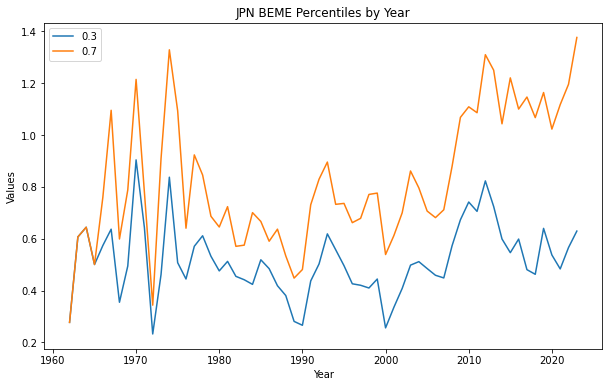

In [15]:
plt.figure(figsize=(10, 6))
for column in jpn_percentiles_by_year.columns[2:4]:
    plt.plot(jpn_percentiles_by_year['year'], jpn_percentiles_by_year[column], label=column)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('JPN BEME Percentiles by Year')
plt.legend()

# Display the plot
plt.show()

In [16]:
usa_percentiles_by_year

AttributeError: 'Index' object has no attribute '_format_flat'

    year         0       0.3       0.7            1
0   1950  1.009681  1.035900  1.125061     1.232586
1   1951  0.949095  0.989565  1.019416     1.023725
2   1952  0.899666  0.941069  0.984334     1.007828
3   1953  0.915733  0.920895  0.950427     0.989562
4   1954  0.770184  0.799313  0.841536     0.875743
..   ...       ...       ...       ...          ...
70  2020  0.000199  0.245632  0.819524  4649.300007
71  2021  0.000012  0.251649  0.740445   184.766240
72  2022  0.000014  0.350118  0.909131  4155.225146
73  2023  0.000008  0.307893  0.851375    26.863818
74  2024  0.003025  0.111992  0.311696     1.689400

[75 rows x 5 columns]

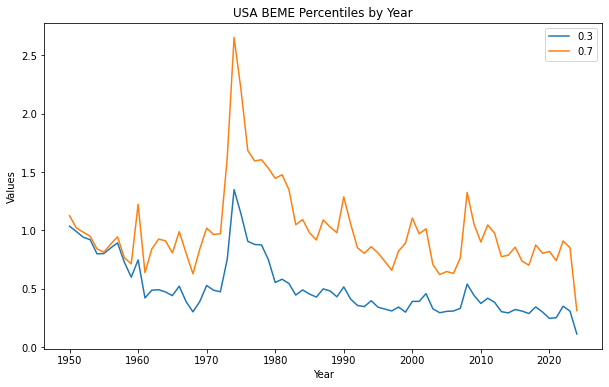

In [17]:
plt.figure(figsize=(10, 6))
for column in usa_percentiles_by_year.columns[2:4]:
    plt.plot(usa_percentiles_by_year['year'], usa_percentiles_by_year[column], label=column)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('USA BEME Percentiles by Year')
plt.legend()

# Display the plot
plt.show()

In [18]:
dnk_percentiles_by_year

AttributeError: 'Index' object has no attribute '_format_flat'

    year         0       0.3       0.7          1
0   1981  0.317259  0.317259  0.317259   0.317259
1   1982  0.308260  0.308260  0.308260   0.308260
2   1983  0.315762  0.315762  0.315762   0.315762
3   1984  0.661014  0.661014  0.661014   0.661014
4   1985  0.734842  0.734842  0.734842   0.734842
5   1986  0.798424  0.798424  0.798424   0.798424
6   1987  1.547563  1.547563  1.547563   1.547563
7   1988  0.818618  0.818618  0.818618   0.818618
8   1989  0.602369  0.602369  0.602369   0.602369
9   1990  0.621177  0.621177  0.621177   0.621177
10  1991  0.483323  0.483323  0.483323   0.483323
11  1992  0.181166  0.235433  0.367846   0.512200
12  1993  0.208338  0.369797  0.481514   0.487629
13  1994  0.413088  0.456998  0.585368   0.684939
14  1995  0.368946  0.381372  0.538642   0.682118
15  1996  0.209933  0.337648  0.442051   0.673405
16  1997  0.203620  0.234818  0.274259   0.520448
17  1998  0.133648  0.213689  0.409742   1.003025
18  1999  0.049349  0.173007  0.423012   1.339782


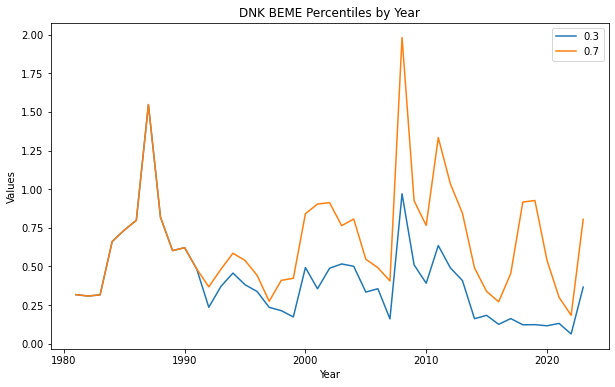

In [19]:
plt.figure(figsize=(10, 6))
for column in dnk_percentiles_by_year.columns[2:4]:
    plt.plot(dnk_percentiles_by_year['year'], dnk_percentiles_by_year[column], label=column)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('DNK BEME Percentiles by Year')
plt.legend()

# Display the plot
plt.show()

In [20]:
# Step 1: Merge the dataframes on the 'year' column
merged_df_jpn = pd.merge(jpn_be, jpn_percentiles_by_year, on='year')
merged_df_usa =  pd.merge(usa_be, usa_percentiles_by_year, on='year')
merged_df_dnk = pd.merge(dnk_be, dnk_percentiles_by_year, on='year')
# Step 2: Define a function to assign portfolio based on quintile
def assign_portfolio(row):
    if row['beme'] >= 0 and row['beme'] < 0.3:
        return 'Growth'
    elif row['beme'] >= 0.3 and row['beme'] < 0.7:
        return 'Neutral'
    elif row['beme'] >= 0.7:
        return 'Value'
    else:
        return None

# Step 3: Apply the function to create a new 'portfolio' column
merged_df_jpn['portfolio'] = merged_df_jpn.apply(assign_portfolio, axis=1)
merged_df_usa['portfolio'] = merged_df_usa.apply(assign_portfolio, axis=1)
merged_df_dnk['portfolio'] = merged_df_dnk.apply(assign_portfolio, axis=1)

# Step 4: Drop unnecessary columns from the merged dataframe
merged_df_jpn = merged_df_jpn.drop(['0', '0.3', '0.7', '1'], axis=1)
merged_df_usa = merged_df_usa.drop(['0', '0.3', '0.7', '1'], axis=1)
merged_df_dnk = merged_df_dnk.drop(['0', '0.3', '0.7', '1'], axis=1)

In [21]:
merged_df_jpn

AttributeError: 'Index' object has no attribute '_format_flat'

       gvkey   datadate  year        be  count  fic    csho     prcc_c  \
0     002721 1974-12-31  1974    77.382      0  JPN   6.052  14.750000   
1     004832 1974-12-31  1974    21.507      9  JPN   4.456   1.750000   
2     004925 1974-10-31  1974   320.460      1  JPN  27.021   8.874975   
3     005650 1974-03-31  1974  1757.618      0  JPN  31.551  43.999992   
4     005691 1974-08-31  1974   366.094      5  JPN  24.350  29.749981   
...      ...        ...   ...       ...    ...  ...     ...        ...   
1414  009818 1973-10-31  1973   419.354     11  JPN  66.250  29.999996   
1415  009818 1962-10-31  1962    22.394      0  JPN   4.200  19.250000   
1416  009818 1963-10-31  1963    28.674      1  JPN   5.400   8.750000   
1417  009818 1964-10-31  1964    31.313      2  JPN   5.400   9.000000   
1418  009818 1965-10-31  1965    34.791      3  JPN   5.400  12.875000   

          beme portfolio  
0     0.866860     Value  
1     2.758015     Value  
2     1.336304     Value  
3  

In [22]:
merged_df_usa

AttributeError: 'Index' object has no attribute '_format_flat'

         gvkey   datadate  year        be  count  fic    csho      prcc_c  \
0       001000 1963-12-31  1963     0.561      2  USA   0.186   10.750000   
1       001010 1963-04-30  1963   142.241     12  USA   1.453   76.999992   
2       001020 1963-12-31  1963    12.653      1  USA   1.162    5.125000   
3       001040 1963-12-31  1963   177.488     13  USA  17.141   19.500000   
4       001045 1963-12-31  1963   227.501     13  USA   8.333   34.500000   
...        ...        ...   ...       ...    ...  ...     ...         ...   
287598  007840 1956-12-31  1956   391.688      6  USA   3.676  132.625000   
287599  008287 1956-12-31  1956  1099.575      6  USA  10.115  123.500000   
287600  007593 1957-12-31  1957   379.471      7  USA   3.505  111.000000   
287601  007840 1957-12-31  1957   392.406      7  USA   3.676  126.000000   
287602  008287 1957-12-31  1957  1297.808      7  USA  11.937  117.750000   

            beme portfolio  
0       0.280570    Growth  
1       1.271360 

In [27]:
merged_df_dnk

AttributeError: 'Index' object has no attribute '_format_flat'

      gvkey   datadate  year         be  count  fic      csho   prcc_c  \
0    008020 1981-12-31  1981    248.422      2  DNK    19.637   39.875   
1    008020 1982-12-31  1982    267.509      3  DNK    19.779   43.875   
2    008020 1983-12-31  1983    390.716      4  DNK    22.096   56.000   
3    008020 1984-12-31  1984    397.422      5  DNK    25.315   23.750   
4    008020 1985-12-31  1985    550.162      6  DNK    25.487   29.375   
..      ...        ...   ...        ...    ...  ...       ...      ...   
140  022604 2022-12-31  2022    281.451      8  DNK    56.039  122.130   
141  037773 2022-12-31  2022      8.303      4  DNK    24.139    1.775   
142  245207 2022-12-31  2022   3942.721      5  DNK   653.717   42.380   
143  008020 2023-12-31  2023  17310.315     44  DNK  4510.000  103.450   
144  015552 2023-12-31  2023  26062.536     22  DNK  1719.547   13.366   

         beme portfolio  
0    0.317259   Neutral  
1    0.308260   Neutral  
2    0.315762   Neutral  
3    0.

In [25]:
return_monthly = db.raw_sql(text("""
                    select gvkey, datadate, trt1m,fic
                    from comp.secm 
                    where datadate >= '01/01/1926'
                    and (fic = 'JPN' or fic = 'USA' or fic = 'DNK')
                    """), date_cols=['datadate'])

In [26]:
return_monthly.to_csv("monthly_return.csv", index=False)

ImportError: cannot import name 'SequenceNotStr' from 'pandas._typing' (/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/pandas/_typing.py)

In [ ]:
return_monthly_usa = return_monthly[return_monthly['fic'] == 'USA']
return_monthly_jpn = return_monthly[return_monthly['fic'] == 'JPN']
return_monthly_dnk = return_monthly[return_monthly['fic'] == 'DNK']
return_monthly_usa = return_monthly_usa[(return_monthly_usa['trt1m'] <= 90) & (return_monthly_usa['trt1m'] >= -90)]
return_monthly_jpn = return_monthly_jpn[(return_monthly_jpn['trt1m'] <= 90) & (return_monthly_jpn['trt1m'] >= -90)]
return_monthly_dnk = return_monthly_dnk[(return_monthly_dnk['trt1m'] <= 90) & (return_monthly_dnk['trt1m'] >= -90)]

In [ ]:
return_monthly_usa

,gvkey,datadate,trt1m,fic
1,001000,1970-10-31,6.3830,USA
2,001000,1970-11-30,-28.0000,USA
3,001000,1970-12-31,11.1111,USA
4,001000,1971-01-31,-10.0000,USA
5,001000,1971-02-28,23.6111,USA
...,...,...,...,...
259168,354003,2023-08-31,-0.4681,USA
259169,354003,2023-09-30,-2.4856,USA
259170,354003,2023-10-31,-1.2372,USA
259171,354003,2023-11-30,5.3729,USA


In [ ]:
summary_stats_usa = return_monthly_usa['trt1m'].describe()
summary_stats_jpn = return_monthly_jpn['trt1m'].describe()
summary_stats_dnk = return_monthly_dnk['trt1m'].describe()
# Creating a DataFrame from the summary statistics
summary_table_usa = pd.DataFrame(summary_stats_usa)
summary_table_jpn = pd.DataFrame(summary_stats_jpn)
summary_table_dnk = pd.DataFrame(summary_stats_dnk)
# Renaming the column for better clarity
summary_table_usa.columns = ['Summary Statistics USA']
summary_table_jpn.columns = ['Summary Statistics JPN']
summary_table_dnk.columns = ['Summary Statistics DNK']

In [ ]:
summary_table_usa

,Summary Statistics USA
count,5.412933e+06
mean,-6.898071e-01
std,1.814277e+01
min,-9.000000e+01
25%,-6.616800e+00
50%,0.000000e+00
75%,5.405400e+00
max,9.000000e+01


In [ ]:
summary_table_jpn

,Summary Statistics JPN
count,53766.000000
mean,0.737009
std,9.531151
min,-89.950000
25%,-4.671275
50%,0.383850
75%,5.731250
max,89.623700


In [ ]:
summary_table_dnk

,Summary Statistics DNK
count,4157.000000
mean,0.756530
std,11.984275
min,-88.417100
25%,-4.939000
50%,0.809900
75%,6.666700
max,70.089900


In [ ]:
import pandas as pd

def calculate_portfolio_returns(return_monthly, merged_df):
    # Step 1: Extract year from return_monthly dataframe
    return_monthly['year'] = pd.to_datetime(return_monthly['datadate']).dt.year

    # Step 2: Filter merged_df for Growth and Value stocks
    growth_stocks = merged_df[merged_df['portfolio'] == 'Growth']
    value_stocks = merged_df[merged_df['portfolio'] == 'Value']

    # Step 3: Merge with return_monthly using both gvkey and year
    merged_growth_returns = pd.merge(growth_stocks, return_monthly, left_on=['gvkey', 'year'], right_on=['gvkey', 'year'], how='inner', suffixes=('_growth', '_return'))
    merged_value_returns = pd.merge(value_stocks, return_monthly, left_on=['gvkey', 'year'], right_on=['gvkey', 'year'], how='inner', suffixes=('_value', '_return'))

    
    merged_growth_returns['total_return'] = -1 * (merged_growth_returns['trt1m'] * (merged_growth_returns['count'] / merged_growth_returns.groupby('datadate_growth')['count'].transform('sum')))
    merged_value_returns['total_return'] = merged_value_returns['trt1m'] * (merged_value_returns['count'] / merged_value_returns.groupby('datadate_value')['count'].transform('sum'))

#     # Print Growth and Value returns
#     print("Growth Returns:")
#     print(merged_growth_returns.groupby('datadate_return')['total_return'].sum().reset_index())

#     print("\nValue Returns:")
#     print(merged_value_returns.groupby('datadate_return')['total_return'].sum().reset_index())

    # Combine Growth and Value returns
    combined_returns = pd.concat([merged_growth_returns, merged_value_returns])

    # Calculate total portfolio return for each month as the sum
    portfolio_returns = combined_returns.groupby('datadate_return')['total_return'].sum().reset_index()
    return portfolio_returns


In [ ]:
bme_monthly_jpn = calculate_portfolio_returns(return_monthly_jpn, merged_df_jpn)


In [ ]:
bme_monthly_usa = calculate_portfolio_returns(return_monthly_usa, merged_df_usa)


In [ ]:
bme_monthly_dnk = calculate_portfolio_returns(return_monthly_dnk, merged_df_dnk)


In [ ]:
bme_monthly_jpn

,datadate_return,total_return
0,1968-02-29,-0.454536
1,1968-03-31,0.173155
2,1968-04-30,-3.883473
3,1968-05-31,-1.098573
4,1968-06-30,0.554318
...,...,...
666,2023-08-31,0.467724
667,2023-09-30,0.859851
668,2023-10-31,-3.984027
669,2023-11-30,-10.281533


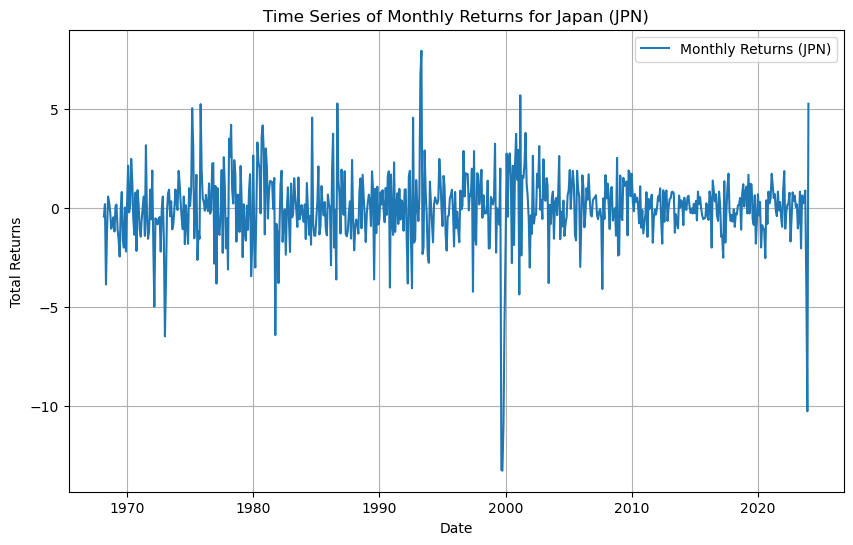

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bme_monthly_jpn['datadate_return'], bme_monthly_jpn['total_return'], label='Monthly Returns (JPN)')
plt.title('Time Series of Monthly Returns for Japan (JPN)')
plt.xlabel('Date')
plt.ylabel('Total Returns')
plt.legend()
plt.grid(True)
plt.show()

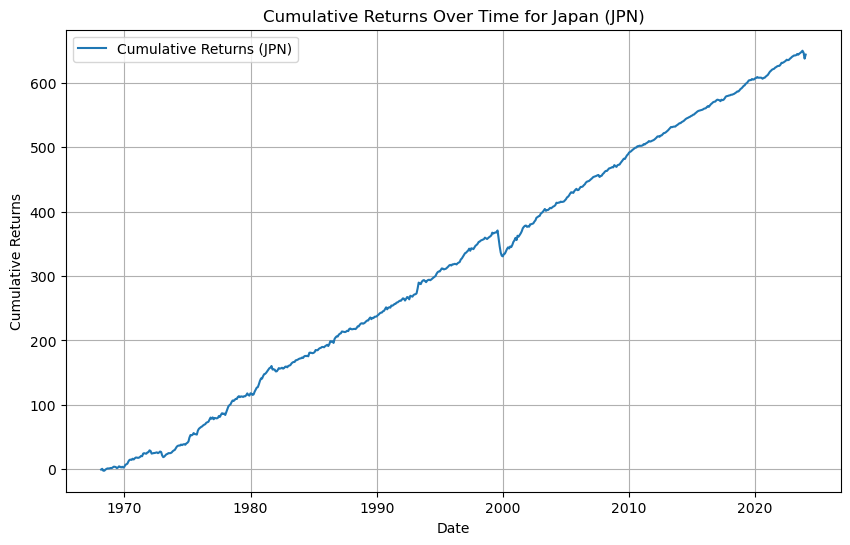

In [ ]:
bme_monthly_jpn['cumulative_return'] = (1 + bme_monthly_jpn['total_return']).cumsum() - 1

plt.figure(figsize=(10, 6))
plt.plot(bme_monthly_jpn['datadate_return'], bme_monthly_jpn['cumulative_return'], label='Cumulative Returns (JPN)')
plt.title('Cumulative Returns Over Time for Japan (JPN)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

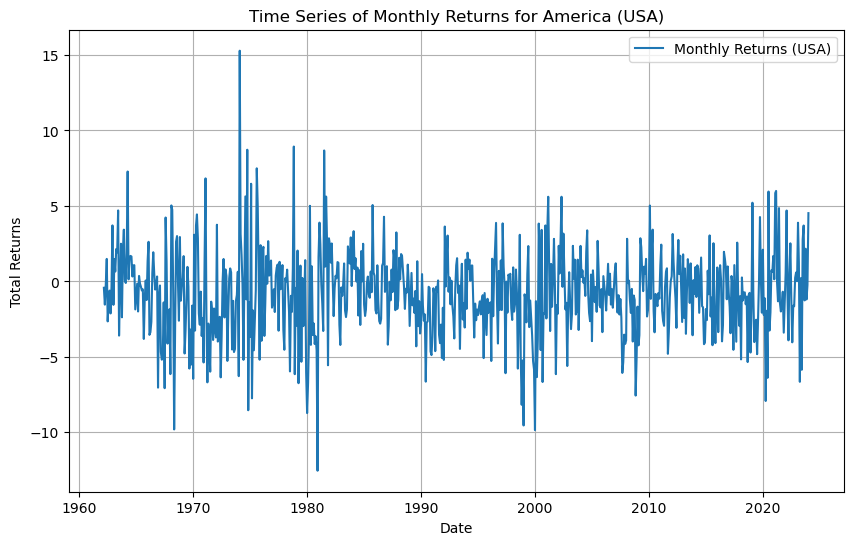

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bme_monthly_usa['datadate_return'], bme_monthly_usa['total_return'], label='Monthly Returns (USA)')
plt.title('Time Series of Monthly Returns for America (USA)')
plt.xlabel('Date')
plt.ylabel('Total Returns')
plt.legend()
plt.grid(True)
plt.show()

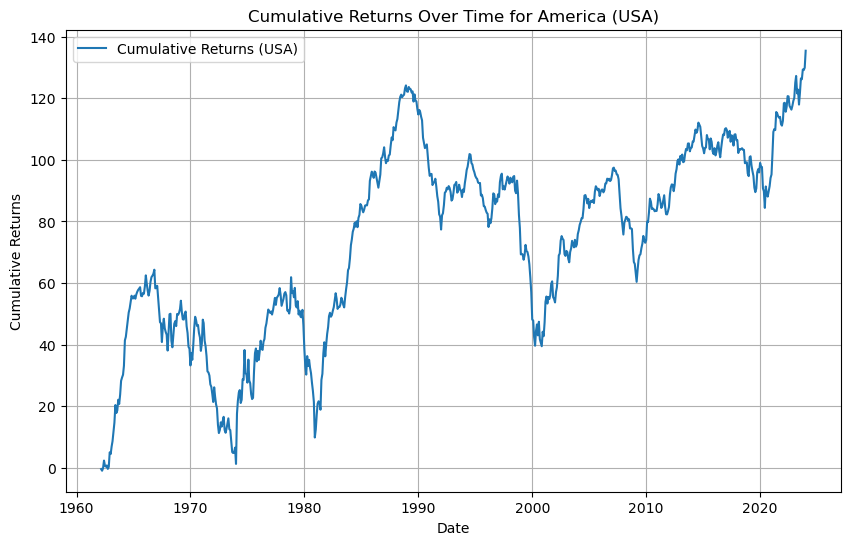

In [ ]:
bme_monthly_usa['cumulative_return'] = (1 + bme_monthly_usa['total_return']).cumsum() - 1

plt.figure(figsize=(10, 6))
plt.plot(bme_monthly_usa['datadate_return'], bme_monthly_usa['cumulative_return'], label='Cumulative Returns (USA)')
plt.title('Cumulative Returns Over Time for America (USA)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

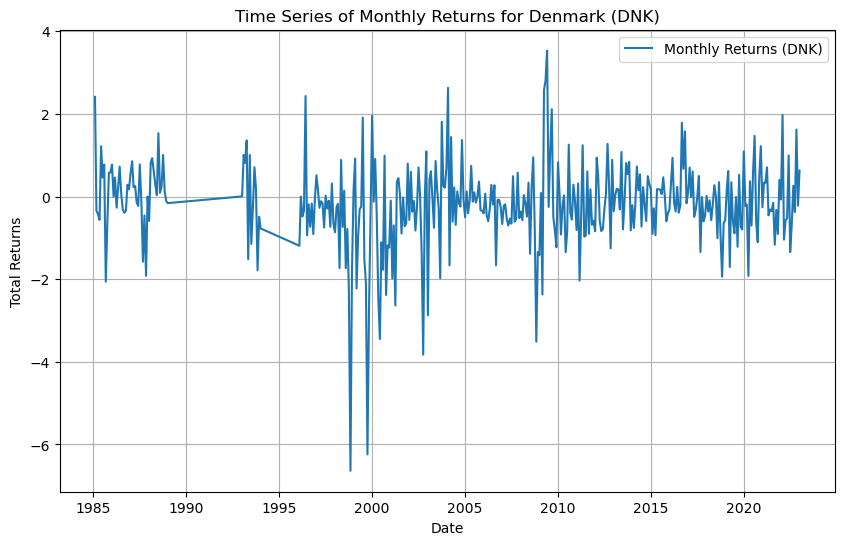

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bme_monthly_dnk['datadate_return'], bme_monthly_dnk['total_return'], label='Monthly Returns (DNK)')
plt.title('Time Series of Monthly Returns for Denmark (DNK)')
plt.xlabel('Date')
plt.ylabel('Total Returns')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
bme_monthly_dnk['cumulative_return'] = (1 + bme_monthly_dnk['total_return']).cumsum() - 1

plt.figure(figsize=(10, 6))
plt.plot(bme_monthly_dnk['datadate_return'], bme_monthly_dnk['cumulative_return'], label='Cumulative Returns (DNK)')
plt.title('Cumulative Returns Over Time for Denmark (DNK)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'bme_monthly_dnk' is not defined

In [42]:
date = """'1986-01-07'"""

In [43]:
list_of_stock_ids = """'7952'"""

In [44]:
data_df = db.raw_sql(text("""
SELECT a.date, a.prc, b.shrout
FROM crsp.dsf AS a
JOIN crsp.dse AS b
ON a.permco = b.permco AND a.date = b.date
WHERE a.date = """+date+""" AND a.permco IN ("""+list_of_stock_ids+""")
"""))

In [45]:
data_df

AttributeError: 'Index' object has no attribute '_format_flat'

         date     prc  shrout
0  1986-01-07 -2.5625     NaN
1  1986-01-07 -2.5625     NaN
2  1986-01-07 -2.5625  3680.0

In [46]:
data_df['prc'] = data_df['prc'].abs()
data_df['market_cap'] = data_df['prc'] * data_df['shrout']

# Want to pull price, shrout, and market values for each stock at each quarter - compare prc*shrout to mv (could be different because of preferred shares, etc.)


market_cap_summary = data_df['market_cap'].describe()
print(market_cap_summary)

# Security with the largest market cap
largest_market_cap = data_df.loc[data_df['market_cap'].idxmax()]

count       1.0
mean     9430.0
std         NaN
min      9430.0
25%      9430.0
50%      9430.0
75%      9430.0
max      9430.0
Name: market_cap, dtype: float64


In [47]:
largest_market_cap

date          1986-01-07
prc               2.5625
shrout            3680.0
market_cap        9430.0
Name: 2, dtype: object

In [48]:
data_df.to_csv('market_cap_data.csv', index=False)

ImportError: cannot import name 'SequenceNotStr' from 'pandas._typing' (/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/pandas/_typing.py)